# Main data analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from shapely.geometry import Point
import geopandas as geop

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 120

Toca:
1. Ver que tanta gente hay en los hospitales importantes
2. Ver que tan lejos estan de las estaciones de trasmi
3. Con los datos de movilidad de bici, determinar una distancia maxima a la que la gente podria moverse

Luego dos partes:
1. Que porcentaje de la gente que esta alrededor del hospital puede lograr movilizarse solo en bici. Calcular cuantas para poner bicis en el hospital, o darle bicis a esas personas.
2. Que porcentage le toca en trasmi. Aca es mas dificil porque falta la parte de saber de donde van a venir para organizar las rutas

A partir de aca dependiendo de cual es la mayoria impactada entre bicicleta/TM, podemos evaluar estrategias para cada una. Por ejemplo en bicicletas priorizar y en tm optimizar rutas

In [3]:
# read data
# ips_geo (viene de `data_processing.ipynb`)
ips_geo_important =pd.read_parquet('../data/02_processed/ips_geo_important.parquet')
# capacities_per_nit (viene de `people.ipynb`)
# capacities_per_nit = pd.read_parquet('../data/02_processed/capacities_per_nit.parquet')
# capacities_per_name (viene de `people.ipynb`)
capacities_per_name = pd.read_parquet('../data/02_processed/capacities_per_name.parquet')
# estaciones (`data_processing.ipynb`)
estaciones= pd.read_parquet('../data/02_processed/estaciones.parquet')

In [4]:
capacities_per_name.sort_values('capacidad', ascending=False)

,nit_ips,nombre_ips,capacidad
100,900210981,HOSPITAL UNIVERSITARIO MAYOR-MEDERI,585.0
71,860007373,FUNDACION HOSPITAL SAN CARLOS,378.0
52,830040256,HOSPITAL MILITAR CENTRAL,345.0
81,860037950,FUNDACION SANTA FE DE BOGOTA,305.0
80,860035992,FUNDACION CARDIO INFANTIL INSTITUTO DE CARDIOL...,285.0
...,...,...,...
62,860005114,LINDE COLOMBIA S.A. - AGENCIA BUCARAMANGA,1.0
60,860005114,LINDE COLOMBIA AGENCIA REMEO CENTER BOGOTA,1.0
63,860005114,LINDE COLOMBIA S.A. - AGENCIA CARTAGENA,1.0
6,800149169,IPS CLINICA JOSE A RIVAS S.A. OTORRINOLARINGOL...,1.0


In [5]:
# add capacities to ips
ips_geo_cap = pd.merge(
    ips_geo_important,
    capacities_per_name.drop('nit_ips', axis=1),
    on='nombre_ips',
    how='inner'
)

In [6]:
ips_geo_cap.shape

(112, 9)

In [7]:
ips_geo_cap.to_csv('../data/02_processed/ips_geo_cap.csv')

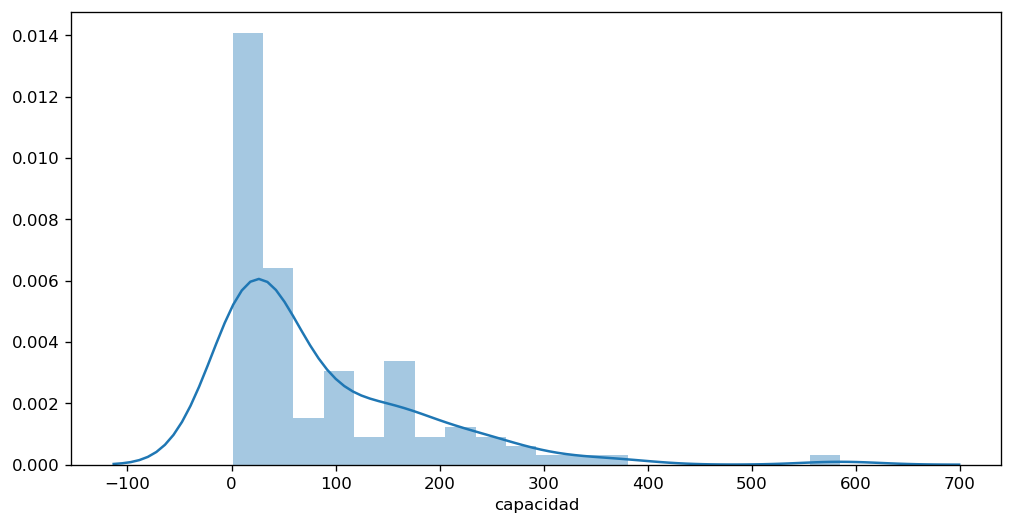

In [8]:
sns.distplot(ips_geo_cap.capacidad, bins=20)

La mayoria de capacidad des son entre 100 y 200. No obstante aca los outlier son importantes, pues seran los hospitales mas concurridos y con mas personal. Podemos sin embargo filtrar el 5% mas pequenho

In [9]:
ips_geo_cap.sort_values('capacidad').head(10)

,direccion,clase_de_prestador,nit_ips,codigo_de_habilitacion,id_ips,nombre_ips,longitud_ips,latitud_ips,capacidad
74,AK 19 No. 100-88,Instituciones - IPS,800149169,110010857501,581,IPS CLINICA JOSE A RIVAS S.A. OTORRINOLARINGOL...,-74.051524,4.687232,1.0
85,AK 14 No. 40A- 04,Instituciones - IPS,860005114,110011509902,1401,LINDE COLOMBIA AGENCIA REMEO CENTER BOGOTA,-74.068238,4.627990,1.0
31,AK 19 N 100-28,Instituciones - IPS,800149169,110010857502,18,CLINICA JOSE A RIVAS VIP,-74.051649,4.686519,2.0
90,Cra 71 127-11,Instituciones - IPS,900169766,110011766701,2274,SANESA UNIDAD QUIRURGICA Y ESTETICA,-74.076529,4.710633,2.0
49,CL 106 # 17 45,Instituciones - IPS,800006602,110010872001,1755,CLINICA AVELLANEDA HERNANDEZ S.A.S.,-74.048682,4.691447,3.0
44,CARRERA 45 A N° 95 - 57,Instituciones - IPS,900210768,110011934101,1267,CIRUGÍA PLÁSTICA LA CASTELLANA S.A.S.,-74.058754,4.684308,3.0
47,Calle 20 No. 98-62,Instituciones - IPS,900385628,110012156401,1577,Medicentro Familiar IPS SAS,-74.142125,4.674393,4.0
28,TRANSVERSAL 116C Nº133-18,Instituciones - IPS,900971006,110013029116,2870,UNIDAD DE SERVICIOS DE SALUD GAITANA I,-74.110283,4.740902,4.0
65,KR 9 B No. 75 - 49 SUR,Instituciones - IPS,900958564,110013029431,2910,UNIDAD DE SERVICIOS DE SALUD SANTA LIBRADA I,-74.113482,4.514656,5.0
104,CALLE 64 C # 121 - 76,Instituciones - IPS,900971006,110013029104,2861,UNIDAD DE SERVICIOS DE SALUD EMAUS,-74.140436,4.715300,5.0


In [10]:
ips_geo_cap.capacidad.quantile(q=[0.05, 0.1, 0.15, 0.2])

0.05     3.55
0.10     6.00
0.15     8.00
0.20    10.00
Name: capacidad, dtype: float64

a partir del 20% comenzamos a tener IPS de capacidad razonable

In [11]:
ips_geo_cap = ips_geo_cap.loc[lambda x: x.capacidad>10]

## Asignacion de personal a cada ips

Analisis de las categorias explicado en el anexo de analisis. Aca implementamos la tabla resultado

In [12]:
cuts = np.concatenate((np.arange(0, 500, 50).astype(float), [float('Inf')]))
empleados = np.arange(100, 901, 100)
capacidad_bin = pd.cut(ips_geo_cap.capacidad, bins=cuts, retbins=False)
bins = capacidad_bin.cat.categories

map_dict = dict(zip(bins, empleados))

#assign the mapping
ips_geo_cap['empleados'] = capacidad_bin.map(map_dict)

In [13]:
ips_empleados = ips_geo_cap[['id_ips', 'capacidad', 'empleados']]

load here file with cap and estimated workers (this step was done manually, details in documentation)

In [14]:
# no es necesario ya, al tener el mapeo en codigo
#ips_empleados = pd.read_csv('../data/02_processed/ips_geo_capacidad_empleados.csv', sep=';')
#ips_empleados.columns = ['nombre_ips', 'capacidad', 'empleados']

#ips_empleados=ips_empleados.loc[lambda x: x.capacidad>40]

In [16]:
ips_empleados.empleados.sum()

21600.0

## De donde viene la gente a las ips? (region de la ips)

In [17]:
# load utam data
utam = pd.read_pickle('../data/02_processed/utam.pkl')
utam_basic = utam[['utam', 'hogares', 'geometry', 'centroide']]

In [18]:
# load viajes_vol
viajes_vol = pd.read_parquet('../data/02_processed/viajes_vol.parquet')
viajes_vol.columns

Index(['utam_origen', 'utam_destino', 'viajeros'], dtype='object')

In [19]:
ips_geo_utam = geop.sjoin(
    geop.GeoDataFrame(ips_geo_cap,
                      geometry=geop.points_from_xy(ips_geo_cap.longitud_ips, ips_geo_cap.latitud_ips)),
    utam_basic,
    how='inner',
    op='intersects'
).drop(columns='index_right', axis=1).rename(columns={'utam':'utam_ips','hogares':'hogares_ips', 'centroide':'centroide_ips'})

ips_geo_utam.columns

C:\Users\User\Anaconda3\envs\movilidad\lib\site-packages\geopandas\tools\sjoin.py:58: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4686'})
  warn(


Index(['direccion', 'clase_de_prestador', 'nit_ips', 'codigo_de_habilitacion',
       'id_ips', 'nombre_ips', 'longitud_ips', 'latitud_ips', 'capacidad',
       'empleados', 'geometry', 'utam_ips', 'hogares_ips', 'centroide_ips'],
      dtype='object')

In [20]:
ips_geo_utam.shape

(87, 14)

Unimos la informacion de viajes

In [21]:
ips_geo_utam = pd.merge(
    ips_geo_utam,
    viajes_vol,
    left_on='utam_ips',
    right_on='utam_destino',
    how='left'
).drop('utam_destino', axis=1)

In [22]:
# merge utam destination information
ips_geo_utam = pd.merge(ips_geo_utam, utam_basic[['utam', 'geometry']], left_on='utam_origen', right_on='utam', suffixes=('_ips', '_origen'))

Calculo de distancia utam origen a IPS

In [23]:
ips_geo_utam = ips_geo_utam.assign(distancia=lambda x: (1/1000)*geop.GeoSeries(x.geometry_ips,crs={'init':'epsg:4326'}).to_crs(epsg=3310).distance(geop.GeoSeries(x.geometry_origen,crs={'init':'epsg:4326'}).to_crs(epsg=3310)))

In [24]:
ips_geo_utam.head()

,direccion,clase_de_prestador,nit_ips,codigo_de_habilitacion,id_ips,nombre_ips,longitud_ips,latitud_ips,capacidad,empleados,geometry_ips,utam_ips,hogares_ips,centroide_ips,utam_origen,viajeros,utam,geometry_origen,distancia
0,AC 33 # 14 37,Instituciones - IPS,830099212,110010905601,4,CENTRO DE INVESTIGACIONES ONCOLOGICAS CLINICA ...,-74.069838,4.621248,99.0,200.0,POINT (-74.06984 4.62125),UTAM91,2421.0,POINT (-74.06594 4.61988),UTAM10,217.663029,UTAM10,"POLYGON ((-74.02110 4.75705, -74.02110 4.75704...",12.848687
1,CARRERA 5 NUMERO 33 A-45,Instituciones - IPS,900959051,110013028915,2845,UNIDAD DE SERVICIOS DE SALUD PERSEVERANCIA,-74.065509,4.619988,18.0,100.0,POINT (-74.06551 4.61999),UTAM91,2421.0,POINT (-74.06594 4.61988),UTAM10,217.663029,UTAM10,"POLYGON ((-74.02110 4.75705, -74.02110 4.75704...",12.773993
2,CRA 8 # 17 45 SUR,Instituciones - IPS,860015888,110010566801,412,HOSPITAL UNIVERSITARIO CLINICA SAN RAFAEL,-74.091331,4.576651,226.0,500.0,POINT (-74.09133 4.57665),UTAM33,12900.0,POINT (-74.08552 4.57808),UTAM10,693.688272,UTAM10,"POLYGON ((-74.02110 4.75705, -74.02110 4.75704...",17.927557
3,CARRERA 8#17-44 SUR,Instituciones - IPS,860015888,110010566809,2974,HOSPITAL UNIVERSITARIO CLINICA SAN RAFAEL,-74.090281,4.575977,226.0,500.0,POINT (-74.09028 4.57598),UTAM33,12900.0,POINT (-74.08552 4.57808),UTAM10,693.688272,UTAM10,"POLYGON ((-74.02110 4.75705, -74.02110 4.75704...",17.933563
4,CRA 8 # 0 29 SUR,Instituciones - IPS,899999032,110010922401,676,EMPRESA SOCIAL DEL ESTADO HOSPITAL UNIVERSITAR...,-74.083710,4.587218,192.0,400.0,POINT (-74.08371 4.58722),UTAM33,12900.0,POINT (-74.08552 4.57808),UTAM10,693.688272,UTAM10,"POLYGON ((-74.02110 4.75705, -74.02110 4.75704...",16.594636


In [25]:
ips_geo_utam.columns

Index(['direccion', 'clase_de_prestador', 'nit_ips', 'codigo_de_habilitacion',
       'id_ips', 'nombre_ips', 'longitud_ips', 'latitud_ips', 'capacidad',
       'empleados', 'geometry_ips', 'utam_ips', 'hogares_ips', 'centroide_ips',
       'utam_origen', 'viajeros', 'utam', 'geometry_origen', 'distancia'],
      dtype='object')

Con estos datos necesitamos saber por cada ips
1. Que tan lejos estan los viajeros
2. Que proporcion es bike_eligible: a mas de 1km (caminar es mas practico) ya menos de 7 km(mas que esto y la bicicleta tiene commute times muy largos)

In [26]:
bike_eligibility = (ips_geo_utam.
     assign(likely_mode=lambda x: np.select([x.distancia < 1,  x.distancia.between(1,7.5), x.distancia > 7.5],
                                           ['pie', 'bicicleta', 'publico'])).
     groupby(['id_ips','likely_mode']).agg({'viajeros': 'sum'}).
     assign(proporcion=lambda x: x.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))).
     reset_index()
)

In [27]:
bike_eligibility.to_parquet('../data/01_raw/bike_eligibility.parquet')
bike_eligibility

,id_ips,likely_mode,viajeros,proporcion
0,4,bicicleta,12912.053783,35.372238
1,4,pie,2377.386382,6.512789
2,4,publico,21213.914858,58.114973
3,105,bicicleta,7481.272880,34.933070
4,105,pie,1707.105830,7.971163
...,...,...,...,...
256,2969,pie,1959.643840,20.985281
257,2969,publico,2177.924061,23.322783
258,2974,bicicleta,4746.879299,37.929169
259,2974,pie,2697.064061,21.550453


Cuanto del share de viajeros esperamos que sea bike_eligible?

Text(0.5, 1.0, 'Proporcion de modo de viaje hacia las IPS')

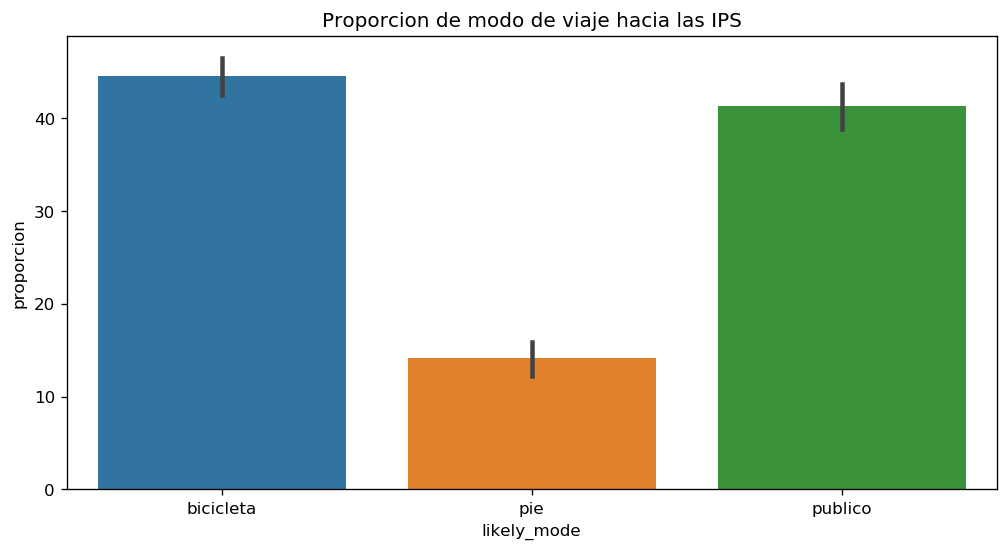

In [28]:
g = sns.barplot(x='likely_mode', y='proporcion', data=bike_eligibility)
g.set_title('Proporcion de modo de viaje hacia las IPS')

In [29]:
bike_eligibility.groupby('likely_mode').agg({'proporcion': ['mean', 'median']})

proporcion           
                  mean     median
likely_mode                      
bicicleta    44.562160  44.557029
pie          14.110421  10.689045
publico      41.327419  42.000487

~44% de los viajes de trabajo(frecuentes) deberian ocurrir a mas de 1km y a menos de 7.5 km de las ips, y deberia ser posible realizarlos en bicicleta

## Cuantas bicicletas serian necesarias?
En una primera aproximacion, podemos usar el numero estimado de personal multiplicado por el share de bike_eligibility. Despues, al refinar este esquema, podemos pensar en una rotacion de bicicletas por turnos. Lo cual podria reducir el nuemro de biucicletas por ips a la mitad o a un tercio (dos y tres turnos)

In [30]:
ips_geo_cap.columns

Index(['direccion', 'clase_de_prestador', 'nit_ips', 'codigo_de_habilitacion',
       'id_ips', 'nombre_ips', 'longitud_ips', 'latitud_ips', 'capacidad',
       'empleados', 'geometry'],
      dtype='object')

In [31]:
ips_geo_bikes = (
    ips_geo_cap.
    merge(bike_eligibility.loc[lambda x:x.likely_mode=='bicicleta'][['id_ips', 'proporcion']],
          on='id_ips').
    assign(expected_bikes = lambda x: np.round(x.empleados*x.proporcion/100))
)

ips_geo_bikes.head()

,direccion,clase_de_prestador,nit_ips,codigo_de_habilitacion,id_ips,nombre_ips,longitud_ips,latitud_ips,capacidad,empleados,geometry,proporcion,expected_bikes
0,AC 33 # 14 37,Instituciones - IPS,830099212,110010905601,4,CENTRO DE INVESTIGACIONES ONCOLOGICAS CLINICA ...,-74.069838,4.621248,99.0,200.0,POINT (-74.06984 4.62125),35.372238,71.0
1,CRA 8 # 17 45 SUR,Instituciones - IPS,860015888,110010566801,412,HOSPITAL UNIVERSITARIO CLINICA SAN RAFAEL,-74.091331,4.576651,226.0,500.0,POINT (-74.09133 4.57665),50.438463,252.0
2,CARRERA 8#17-44 SUR,Instituciones - IPS,860015888,110010566809,2974,HOSPITAL UNIVERSITARIO CLINICA SAN RAFAEL,-74.090281,4.575977,226.0,500.0,POINT (-74.09028 4.57598),37.929169,190.0
3,DIAG 115 A # 70 C 75,Instituciones - IPS,860006656,110010644701,433,FUNDACION ABOOD SHAIO,-74.072870,4.698066,247.0,500.0,POINT (-74.07287 4.69807),59.945174,300.0
4,CL 45 F # 16 A 11,Instituciones - IPS,860010783,110010752101,491,CLINICA NUEVA,-74.070961,4.634261,95.0,200.0,POINT (-74.07096 4.63426),34.587858,69.0


In [32]:
# guardamos estos datos en resultados
ips_geo_bikes.to_csv('../data/03_results/ips_bikes.csv')

Este resultado nos da el estimado de bicicletas necesarias por cada ips. En total tendriamos

In [33]:
ips_geo_bikes.expected_bikes.sum()

9819.0

Esta cifra es alcanzable teniendo en cuenta la disponibilidad de bibicletas del distrito y que es posible lanzar una campanha donde las personas presten su bicicleta durante la crisis. Yas que bogota cuenta con alrededor de 800k bicicletas. Una de cada 20 usuarias de bicicleta necesitarian prestar su bicicleta. no obstante, si esta iniciativa resulta dificil, podemos manejar un esquema de priorizacion.

## Priorizacion de asignacion de bicicletas
Podemos proponer una priorizacin de asignacion de bicicletas teniendo en cuenta los siguientes factores:

1. IPS mas grandes deberian tener mayor prioridad, tenemos la estimacion de camas
2. IPS en zonas mas densas deberian tener mayor prioridad, pues van a tender a recibir mas casos mas rapido. Podemos estimar esto con los datos de numero de hogares en datos de utam 
3. IPS mas cerca a transporte publico deberia tener menor prioridad. Tratamos esto a continuacion

## Que tan lejos se encuentran estaciones de transmilenio de los hospitales principales
Para aproximadamente 37% de los empleados la solucion de bicicletas no es viable. Al mismo tiempo, podria haber una dificultad en obtener el numero necesario de bicicletas

Este analisis tambien nos servira para obtener las distancias de las IPS a transporte publico

In [34]:
# merge ips and estaciones data
ips_estaciones = pd.merge(
    ips_geo_cap.assign(key=1),
    estaciones.assign(key=1),
    on = 'key'
).drop('key', axis=1)

In [35]:
ips_estaciones.shape

(13112, 23)

In [36]:
ips_estaciones.head()

,direccion,clase_de_prestador,nit_ips,codigo_de_habilitacion,id_ips,nombre_ips,longitud_ips,latitud_ips,capacidad,empleados,...,ubicacion_estacion,troncal_estacion,numero_vagones_estacion,numero_accesos_estacion,biciestacion_estacion,capacidad_biciestacion_estacion,tipo_estacion,biciparqueadero_estacion,latitud_estacion,longitud_estacion
0,AC 33 # 14 37,Instituciones - IPS,830099212,110010905601,4,CENTRO DE INVESTIGACIONES ONCOLOGICAS CLINICA ...,-74.069838,4.621248,99.0,200.0,...,Carrera 86,Calle 80,1,1,0,0,INTERMEDIA,NO,4.702500,-74.100253
1,AC 33 # 14 37,Instituciones - IPS,830099212,110010905601,4,CENTRO DE INVESTIGACIONES ONCOLOGICAS CLINICA ...,-74.069838,4.621248,99.0,200.0,...,AutoSur-Av 54,NQS,2,1,0,0,SENCILLA,NO,4.595713,-74.141590
2,AC 33 # 14 37,Instituciones - IPS,830099212,110010905601,4,CENTRO DE INVESTIGACIONES ONCOLOGICAS CLINICA ...,-74.069838,4.621248,99.0,200.0,...,Carrera 53,Calle 80,1,1,0,0,SENCILLA,NO,4.681940,-74.077365
3,AC 33 # 14 37,Instituciones - IPS,830099212,110010905601,4,CENTRO DE INVESTIGACIONES ONCOLOGICAS CLINICA ...,-74.069838,4.621248,99.0,200.0,...,Kr 30 CL 63,NQS,2,1,0,0,SENCILLA,NO,4.657063,-74.077754
4,AC 33 # 14 37,Instituciones - IPS,830099212,110010905601,4,CENTRO DE INVESTIGACIONES ONCOLOGICAS CLINICA ...,-74.069838,4.621248,99.0,200.0,...,Carrera 96,Calle 80,0,0,1,353,CABECERA,SI,4.709523,-74.110525


In [37]:
# vectorized haversine function, mas rapida que la de geopandas
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    """
    slightly modified version: of http://stackoverflow.com/a/29546836/2901002

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

In [38]:
# agregar distancia
ips_estaciones = (ips_estaciones.
    assign(distancia=lambda x: haversine(x.latitud_ips, x.longitud_ips,
                                        x.latitud_estacion, x.longitud_estacion))
)

Ahora, encontramos las estaciones mas cercanas a cada centro medico

In [39]:
ips_estaciones = (ips_estaciones.
    assign(dist_rank=lambda x: x.groupby('id_ips').distancia.rank(method='dense'))
)

Seleccionamos la estacion mas cercana, aunque en un analisis mas refinado podemos dejar las estaciones a cierta distancia maxima del las ips, con eso se puede optimizar el transporte a varios puntos

In [40]:
ips_estaciones_top = (ips_estaciones.loc[lambda x:x.dist_rank==1])

In [41]:
# guardamos este resultado intermedio
ips_estaciones_top.to_csv('../data/02_processed/ips_estaciones_top.csv')

In [42]:
ips_estaciones_top.head()

,direccion,clase_de_prestador,nit_ips,codigo_de_habilitacion,id_ips,nombre_ips,longitud_ips,latitud_ips,capacidad,empleados,...,numero_vagones_estacion,numero_accesos_estacion,biciestacion_estacion,capacidad_biciestacion_estacion,tipo_estacion,biciparqueadero_estacion,latitud_estacion,longitud_estacion,distancia,dist_rank
18,AC 33 # 14 37,Instituciones - IPS,830099212,110010905601,4,CENTRO DE INVESTIGACIONES ONCOLOGICAS CLINICA ...,-74.069838,4.621248,99.0,200.0,...,3,2,0,0,SENCILLA,NO,4.622213,-74.069588,0.110898,1.0
238,CRA 8 # 17 45 SUR,Instituciones - IPS,860015888,110010566801,412,HOSPITAL UNIVERSITARIO CLINICA SAN RAFAEL,-74.091331,4.576651,226.0,500.0,...,3,2,0,0,SENCILLA,NO,4.575723,-74.094563,0.372744,1.0
387,CARRERA 8#17-44 SUR,Instituciones - IPS,860015888,110010566809,2974,HOSPITAL UNIVERSITARIO CLINICA SAN RAFAEL,-74.090281,4.575977,226.0,500.0,...,3,2,0,0,SENCILLA,NO,4.575723,-74.094563,0.475371,1.0
487,DIAG 115 A # 70 C 75,Instituciones - IPS,860006656,110010644701,433,FUNDACION ABOOD SHAIO,-74.072870,4.698066,247.0,500.0,...,2,1,0,0,SENCILLA,NO,4.699181,-74.069756,0.366671,1.0
730,CL 45 F # 16 A 11,Instituciones - IPS,860010783,110010752101,491,CLINICA NUEVA,-74.070961,4.634261,95.0,200.0,...,3,2,0,0,SENCILLA,NO,4.633374,-74.067381,0.408929,1.0


Text(0.5, 1.0, 'distancia minima de la IPS a una estacion de TM')

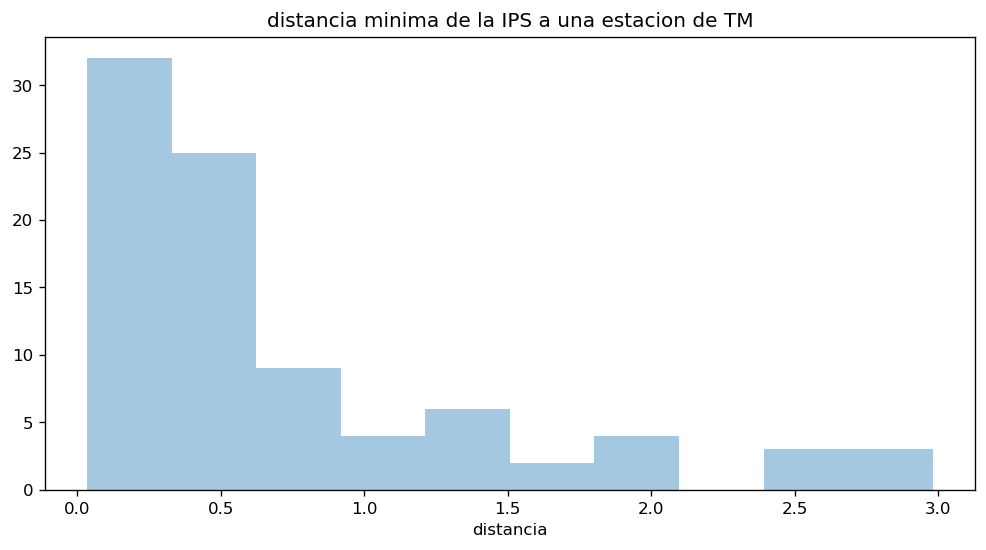

In [43]:
# a quedistancias estan?
g = sns.distplot(ips_estaciones_top.distancia, kde=False)
g.set_title('distancia minima de la IPS a una estacion de TM')

In [44]:
ips_estaciones_top.distancia.quantile(q=np.linspace(0,1,11))

0.0    0.035118
0.1    0.155071
0.2    0.205892
0.3    0.288092
0.4    0.350584
0.5    0.443627
0.6    0.529396
0.7    0.739995
0.8    1.223231
0.9    1.880240
1.0    2.981354
Name: distancia, dtype: float64

## Calculos priorizacion 

Volviendo a la priorizacion:

Podemos proponer una priorizacin de asignacion de bicicletas teniendo en cuenta los siguientes factores:

1. IPS mas grandes deberian tener mayor prioridad, tenemos la estimacion de camas
2. IPS en zonas mas densas deberian tener mayor prioridad, pues van a tender a recibir mas casos mas rapido. Podemos estimar esto con los datos de numero de hogares en datos de utam 
3. IPS mas cerca a transporte publico deberia tener menor prioridad. Tratamos esto a continuacion



In [45]:
ips_geo_bikes.columns

Index(['direccion', 'clase_de_prestador', 'nit_ips', 'codigo_de_habilitacion',
       'id_ips', 'nombre_ips', 'longitud_ips', 'latitud_ips', 'capacidad',
       'empleados', 'geometry', 'proporcion', 'expected_bikes'],
      dtype='object')

In [46]:
ips_estaciones_top.columns

Index(['direccion', 'clase_de_prestador', 'nit_ips', 'codigo_de_habilitacion',
       'id_ips', 'nombre_ips', 'longitud_ips', 'latitud_ips', 'capacidad',
       'empleados', 'geometry', 'numero_estacion', 'nombre_estacion',
       'ubicacion_estacion', 'troncal_estacion', 'numero_vagones_estacion',
       'numero_accesos_estacion', 'biciestacion_estacion',
       'capacidad_biciestacion_estacion', 'tipo_estacion',
       'biciparqueadero_estacion', 'latitud_estacion', 'longitud_estacion',
       'distancia', 'dist_rank'],
      dtype='object')

In [51]:
# capacities_breakdown from (people.ipynb)
capacities_breakdown = pd.read_parquet('../data/02_processed/capacities_breakdown.parquet')
capacities_breakdown.columns

Index(['nit_ips', 'nombre_ips', 'intensivo', 'intermedio', 'normal', 'total',
       'share_intensivo', 'rank_intensivo', 'rank_total'],
      dtype='object', name='categoria_capacidad')

In [52]:
# unimos datos de ips_estaciones_top, y utam para la estimacion de densidad
print(ips_all.columns)
print(ips_all.shape)

ips_all = geop.sjoin(
    geop.GeoDataFrame(ips_geo_bikes,
                      geometry=geop.points_from_xy(ips_geo_bikes.longitud_ips, ips_geo_bikes.latitud_ips)),
    utam_basic,
    how='inner',
    op='intersects'
).drop(columns='index_right', axis=1).rename(columns={'utam':'utam_ips','hogares':'hogares_ips', 'centroide':'centroide_ips'})

print(ips_all.columns)
print(ips_all.shape)

ips_all = pd.merge(
    ips_all,
    ips_estaciones_top[['id_ips', 'nombre_estacion', 'ubicacion_estacion',
                    'troncal_estacion', 'latitud_estacion', 'longitud_estacion',
                    'distancia']],
    how='inner',
    on='id_ips'
)

print(ips_all.columns)
print(ips_all.shape)

ips_all = pd.merge(
    ips_all,
    capacities_breakdown,
    on=['nombre_ips', 'nit_ips']
)

print(ips_all.columns)
print(ips_all.shape)

Index(['direccion', 'clase_de_prestador', 'nit_ips', 'codigo_de_habilitacion',
       'id_ips', 'nombre_ips', 'longitud_ips', 'latitud_ips', 'capacidad',
       'empleados', 'geometry', 'proporcion', 'expected_bikes', 'utam_ips',
       'hogares_ips', 'centroide_ips', 'nombre_estacion', 'ubicacion_estacion',
       'troncal_estacion', 'latitud_estacion', 'longitud_estacion',
       'distancia'],
      dtype='object')
(87, 22)
Index(['direccion', 'clase_de_prestador', 'nit_ips', 'codigo_de_habilitacion',
       'id_ips', 'nombre_ips', 'longitud_ips', 'latitud_ips', 'capacidad',
       'empleados', 'geometry', 'proporcion', 'expected_bikes', 'utam_ips',
       'hogares_ips', 'centroide_ips'],
      dtype='object')
(87, 16)
Index(['direccion', 'clase_de_prestador', 'nit_ips', 'codigo_de_habilitacion',
       'id_ips', 'nombre_ips', 'longitud_ips', 'latitud_ips', 'capacidad',
       'empleados', 'geometry', 'proporcion', 'expected_bikes', 'utam_ips',
       'hogares_ips', 'centroide_ips', 

C:\Users\User\Anaconda3\envs\movilidad\lib\site-packages\geopandas\tools\sjoin.py:58: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4686'})
  warn(


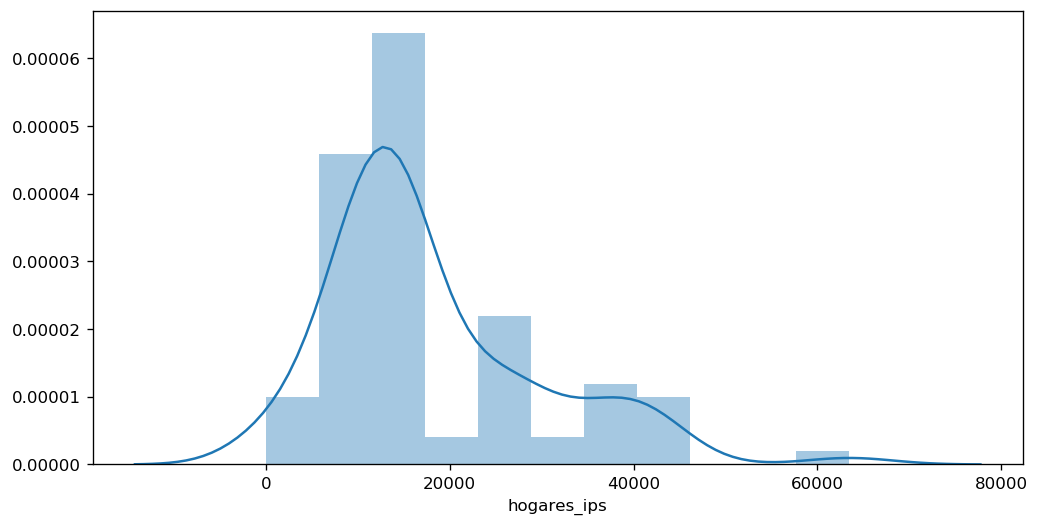

In [53]:
sns.distplot(ips_all.hogares_ips)

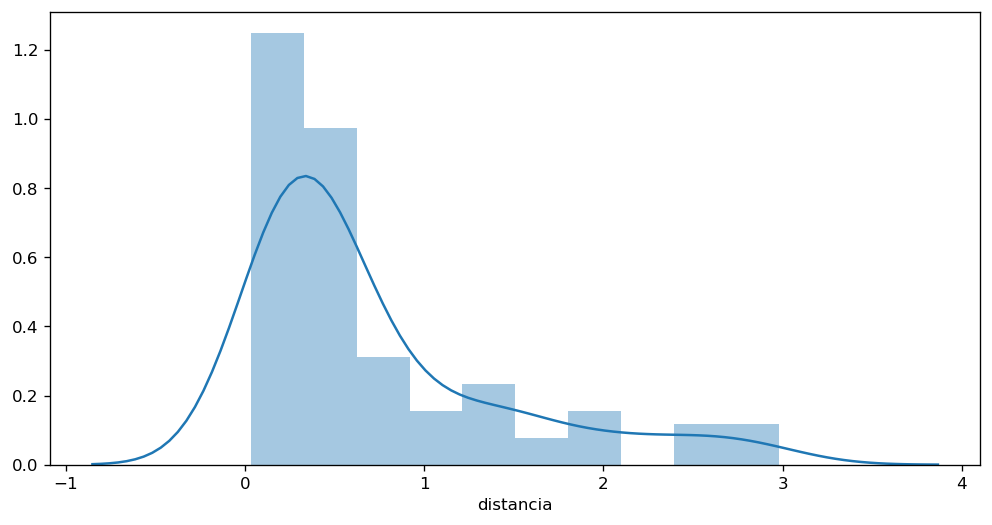

In [54]:
sns.distplot(ips_all.distancia)

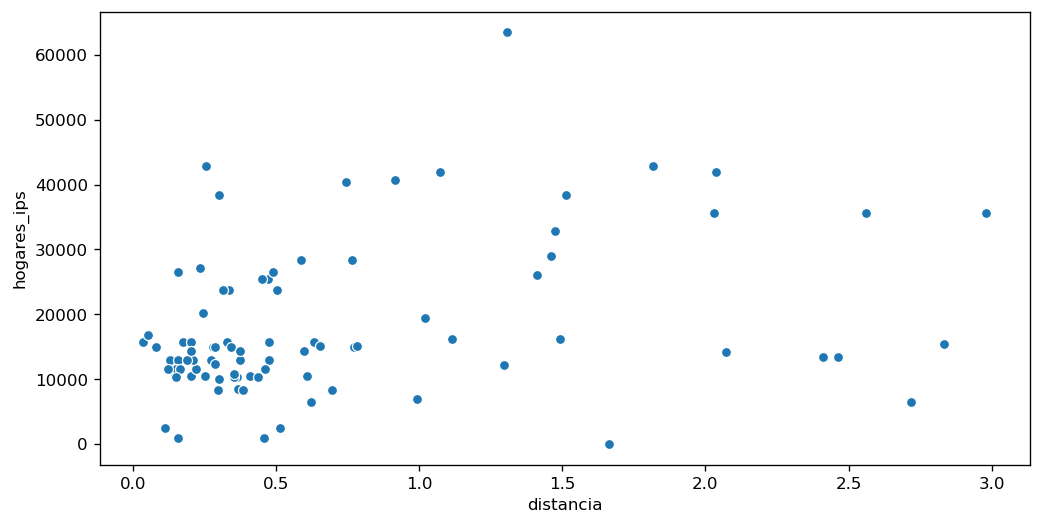

In [55]:
sns.scatterplot(x = 'distancia', y = 'hogares_ips', data=ips_all)

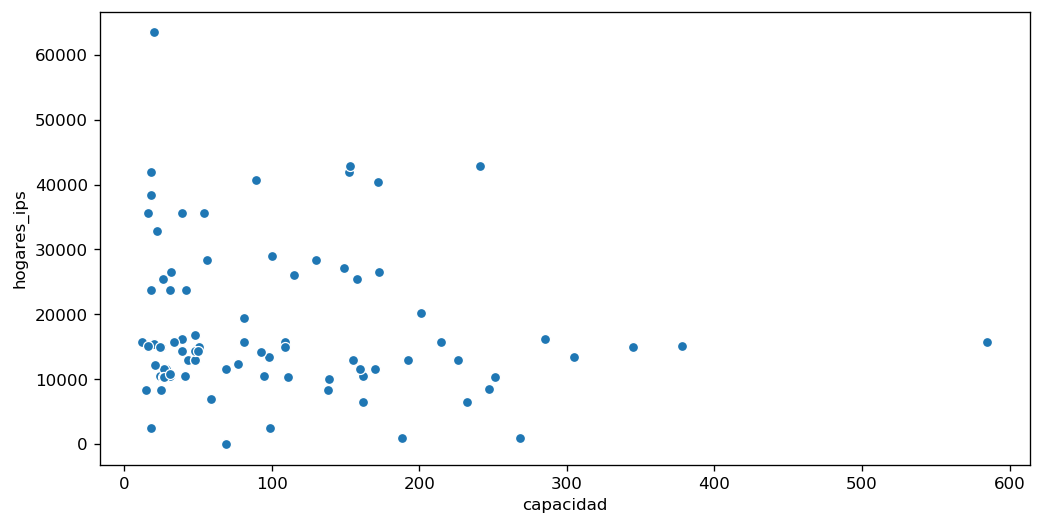

In [56]:
sns.scatterplot(x = 'capacidad', y = 'hogares_ips', data=ips_all)

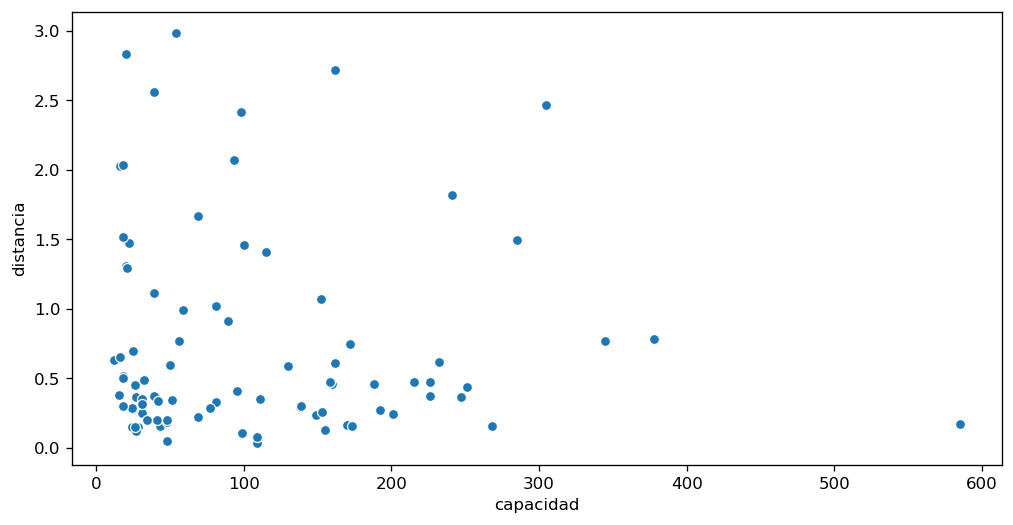

In [57]:
sns.scatterplot(x = 'capacidad', y = 'distancia', data=ips_all)

con estos datos listos, podemos proceder a agrupar y asignar un orden de prioridad.

**Metodo**
- Generamos rangos para: `distancia`, `densidad(hogares)`, `capacidad` y `share_intensivo`. Estas seran nuestras cuatro variables mas importantes para priorizar.
- Volvemos cada una de las variables un score, como tenemos varios outlier y son importantes, hacemos rankings de cuantiles

In [58]:
ips_all = (ips_all.
    assign(rank_share_intensivo=lambda x: x.share_intensivo.rank(method='max', pct=True),
           rank_capacidad=lambda x: x.capacidad.rank(method='max', pct=True),
           rank_distancia=lambda x: x.distancia.rank(method='max', pct=True),
           rank_hogares_ips=lambda x: x.hogares_ips.rank(method='max', pct=True)
          )
)

Creamos un puntaje sumando por igual las categorias. Dependiendo de opiniones de expertos, este score podria cambiar

In [59]:
w_score = np.array([0.25, 0.25, 0.25, 0.25])

priority_scores = 100 * ips_all[['rank_share_intensivo', 'rank_capacidad', 'rank_distancia', 'rank_hogares_ips']].dot(w_score)

ips_all['priority_score'] = priority_scores

In [60]:
ips_all.columns

Index(['direccion', 'clase_de_prestador', 'nit_ips', 'codigo_de_habilitacion',
       'id_ips', 'nombre_ips', 'longitud_ips', 'latitud_ips', 'capacidad',
       'empleados', 'geometry', 'proporcion', 'expected_bikes', 'utam_ips',
       'hogares_ips', 'centroide_ips', 'nombre_estacion', 'ubicacion_estacion',
       'troncal_estacion', 'latitud_estacion', 'longitud_estacion',
       'distancia', 'intensivo', 'intermedio', 'normal', 'total',
       'share_intensivo', 'rank_intensivo', 'rank_total',
       'rank_share_intensivo', 'rank_capacidad', 'rank_distancia',
       'rank_hogares_ips', 'priority_score'],
      dtype='object')

In [65]:
ips_final = ips_all[['nit_ips', 'direccion', 'nombre_ips', 'capacidad', 'empleados',
                     'intensivo', 'share_intensivo',
                     'latitud_ips', 'longitud_ips',
                     'hogares_ips', 'nombre_estacion', 'ubicacion_estacion', 'troncal_estacion',
                     'latitud_estacion', 'longitud_estacion', 'distancia',
                     'expected_bikes', 'priority_score']].sort_values('priority_score', ascending=False)

In [67]:
ips_final.to_csv('../data/03_results/ips_final.csv')

## UTAM de IPS y de estaciones (WIP)
Usaremos el volumen de movilidad como proxy para el numero de trabajadores que van hacia los hospitales con esto, tambien entenderemos que porcentaje de . Primero, necesitamos el utam de los hospitales.

Tenemos que encontrar el UTAM de cada una de las estaciones e IPSs

In [ ]:
ips_estaciones_top = (ips_estaciones_top.
     assign(location_ips=lambda df: df.apply(lambda r: Point(r.longitud_ips, r.latitud_ips), axis=1),
            location_estacion = lambda df: df.apply(lambda r: Point(r.longitud_estacion, r.latitud_estacion), axis=1))
)

In [ ]:
ips_estaciones_top.head()

In [ ]:
ips_estaciones_top_geo = geop.GeoDataFrame(ips_estaciones_top)

In [ ]:
# load utam data
utam = pd.read_pickle('../data/02_processed/utam.pkl')
utam_basic = utam[['utam', 'hogares', 'geometry', 'centroide']]

In [ ]:
ips_geo_1.set_geometry('location_estacion').info()

In [ ]:
# merge utam ips
ips_geo_1 = (geop.sjoin(
    ips_estaciones_top_geo.set_geometry('location_ips'),
    utam_basic,
    how='inner',
    op='intersects'
).rename(columns={'utam':'utam_ips','hogares':'hogares_ips', 'centroide':'centroide_ips'})).drop(['index_right'], axis=1)

#merge estacion utam
ips_geo_utam = geop.sjoin(
    ips_geo_1.set_geometry('location_estacion'),
    utam_basic.set_geometry('geometry'),
    how='inner',
    op='intersects'
).rename(columns={'utam':'utam_estacion','hogares':'hogares_estacion', 'centroide':'centroide_estacion'})

In [ ]:
ips_geo_utam

In [ ]:
ips_geo_1.set_geometry('location_estacion').plot()